# SiMaC: Sinkhorn Matrix Factorization with Capacity Constraints

In [1]:
import sys
sys.path.append("../../SiMaC/")

In [2]:
import os
import pickle
import string
import math
import time

import torch
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import euclidean_distances

from src.dataset.toy import ToyDataset, CIRCLE_RADIUS, save_dataset, load_dataset
from src.ml.model import ModelOT
from src.ml.train import train_model, assign_with_lap, format_training_results_in_dataframes
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

## 1. Dataset generation

### 1.1 Load the toy dataset.

Source code is in `src.dataset.toy.ToyDataset`.

Run this cell to generate a new toy dataset.

In [72]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

In [73]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

In [74]:
# toy = load_dataset("../data/toy.pkl")

### 1.2 Plot the dataset

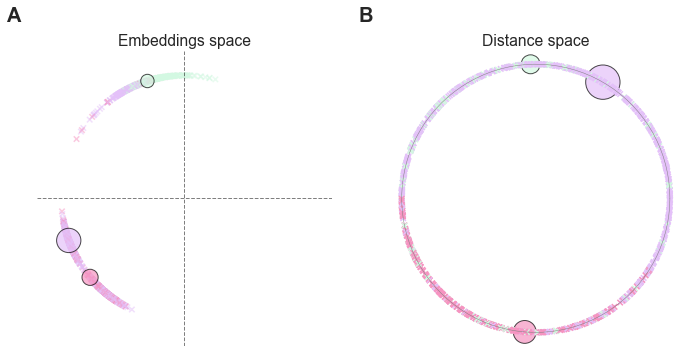

In [75]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    CIRCLE_RADIUS,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [76]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "toy_dataset.png"), dpi=300)

In [77]:
save_dataset(toy, "../data/toy.pkl")

In [78]:
toy.items_capacities

array([[179, 590, 261]])

## 2. Model training

In [28]:
# %autoreload 2

In [81]:
#################
# Declare model #
#################

model = ModelOT(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    epsilon=0.1,
    alpha=0.2,
    n_iter=10,
    n_features=n_features,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)
model.train()

optimizer = torch.optim.Adam(lr=0.05, params=model.parameters())
criterion = torch.nn.NLLLoss()

n_epochs = 400

#########
# Train #
#########

losses = []
scores = []

for epoch in range(n_epochs):
    train_epoch_loss = 0
    optimizer.zero_grad()

    # model out
    r_ij = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    e_usage = r_ij.sum(axis=0)

    # predictions
    # y_pred = torch.argmax(r_ij, axis=1)
    y_pred = assign_with_lap(r_ij, toy.items_capacities)

    # loss function
    loss = criterion(torch.log(r_ij), toy.y_true_tensor)
    train_epoch_loss += loss.item()
    loss.backward()

    # optimizer
    optimizer.step()

    # training loss
    losses.append([loss.item()])

    # training scores
    acc = accuracy_score(y_true=toy.y_true_tensor, y_pred=y_pred)
    f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")
    
    embedding_distance = np.linalg.norm(
        model.item_embeddings.weight.data.numpy() - toy.items_features, axis=1
    )
    
    scores.append([acc, f1, np.mean(embedding_distance)])
    
########################
# Store training stats #
########################

capacities_df, losses_df, scores_df = format_training_results_in_dataframes(
    y_pred, 
    toy.items_capacities,
    e_usage,
    losses,
    scores
)

scores_df.iloc[-1:]

,epoch,acc,f1,distances
399,400,0.938,0.926692,0.647147


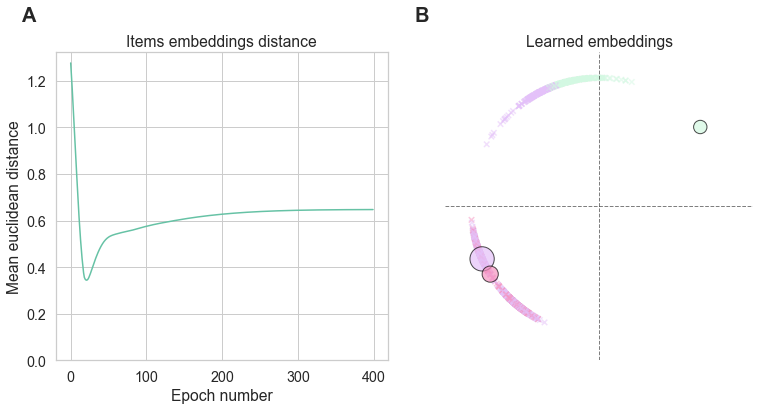

In [82]:
#######################
# Plot training stats #
#######################

fig, axs = plt.subplots(figsize=(11, 6), nrows=1, ncols=2)

# Embeddings distance
scores_df["distances"].plot(kind="line", ax=axs[0])
axs[0].set_xlabel("Epoch number")
axs[0].set_ylabel("Mean euclidean distance")
axs[0].set_title("Items embeddings distance")
axs[0].set_ylim(0, None)

# Learned items embeddings and assigned users
viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    items_features=model.item_embeddings.weight,
    items_capacities=toy.items_capacities,
    y_pred=y_pred,
    ax=axs[1]
)
axs[1].set_title("Learned embeddings")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [84]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "training_results.png"), dpi=300)

## 3. Minibatch training

In [ ]:
%%time

large_dataset = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=10000,
    n_features=n_features,
    distance_weight=distance_weight
)

In [ ]:
batch_experiments = []

for assign in ["lap", "argmax"]:
    for batch_size_ratio in [0.01, 0.05, 0.1, 0.2, 0.3]:
        batch_size = int(batch_size_ratio*large_dataset.n_users)

        data_loader = torch.utils.data.DataLoader(
            large_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        large_model = ModelOT(
            capacities=large_dataset.items_capacities,
            n_users=large_dataset.n_users,
            epsilon=0.05,
            alpha=0.5,
            n_iter=20,
            n_features=2,
            user_embeddings=torch.FloatTensor(large_dataset.users_features),
            train_user_embeddings=False
        )

        large_model.train()

        optimizer = torch.optim.Adam(lr=0.01, params=large_model.parameters())
        criterion = torch.nn.NLLLoss()

        losses = []
        scores = []

        #########
        # Train #
        #########

        start = time.time()
        for _ in range(100):
            train_epoch_loss = 0
            y_pred = []

            optimizer.zero_grad()

            for i, (users_tensor_tmp, items_tensor_tmp, D_tensor_tmp, y_true_tmp) in enumerate(data_loader):
                scaling_factor = users_tensor_tmp.shape[0] / large_dataset.n_users

                r_ij = large_model(users_tensor_tmp, items_tensor_tmp, D_tensor_tmp)
                e_usage = r_ij.sum(axis=0)

                scaled_capacities = np.round(large_dataset.items_capacities * scaling_factor)

                if assign == "lap":
                    y_pred_batch = assign_with_lap(r_ij, scaled_capacities)
                elif assign == "argmax":
                    y_pred_batch = torch.argmax(r_ij, axis=1)

                y_pred += y_pred_batch

                # loss function
                loss = criterion(torch.log(r_ij), y_true_tmp)
                train_epoch_loss += loss.item()
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            train_epoch_loss = train_epoch_loss / (i+1)

        y_pred = [t.item() for t in y_pred]

        # Training time
        elapsed_time = time.time() - start

        # F1 Score
        f1 = f1_score(y_true=large_dataset.y_true_tensor, y_pred=y_pred, average="macro")

        # Overflow
        actual_usage=torch.nn.functional.one_hot(torch.LongTensor(y_pred),
                                                 num_classes=large_dataset.items_capacities.shape[1]
                                                ).sum(axis=0).data.numpy()
        delta = actual_usage - large_dataset.items_capacities
        overflow = np.where(delta <= 0, 0, delta).sum()

        batch_experiments.append(
            dict(
                assign=assign,
                batch_size=batch_size,
                batch_size_ratio=batch_size_ratio,
                f1=f1,
                overflow=overflow,
                training_time=elapsed_time
            )
        )

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 6), sharex=True)

# F1 score
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="f1",
    hue="assign",
    ax=axs[0]
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="f1",
    hue="assign",
    ax=axs[0],
    legend=False
)

axs[0].set_ylim(.7, 1)
axs[0].set_xlabel("Batch size")
axs[0].set_ylabel("F1 Score")

# F1 score
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="overflow",
    hue="assign",
    ax=axs[1],
    legend=False
)

axs[1].set_xlabel("Batch size")
axs[1].set_ylabel("Overflow")

# Training time
sns.scatterplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="training_time",
    hue="assign",
    ax=axs[2],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(batch_experiments),
    x="batch_size",
    y="training_time",
    hue="assign",
    ax=axs[2],
    legend=False
)

axs[2].set_xlabel("Batch size")
axs[2].set_ylabel("Training time (seconds)")


# Annotate with letters
for i in range(3):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [ ]:
# fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "batch_size.png"), dpi=300)

## 4. Experiments

### 4.1 Epsilon influence

In [117]:
results_tmp = []

for epsilon in [0.03, 0.05, 0.08, 0.1, 0.3 ,0.5, 0.8, 1]:
    y_pred_tmp, _, _, scores_df_tmp, capacities_df_tmp = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01,
        epsilon=epsilon, 
        n_iter=10,
        alpha=0.3, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False,
        assign="lap"
    )

    results_tmp.append(
        dict(
            epsilon=epsilon,
            assign=assign,
            f1=scores_df_tmp["f1"].iloc[-1],
            distances=scores_df_tmp["distances"].iloc[-1]
        )
    )

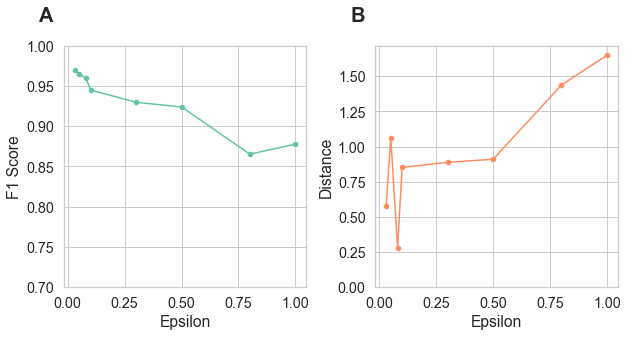

In [126]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True
)

############
# F1 score #
############
sns.scatterplot(
    data=pd.DataFrame(results_tmp),
    x="epsilon",
    y="f1",
    ax=axs[0],
    color=sns.color_palette()[0]
)

sns.lineplot(
    data=pd.DataFrame(results_tmp),
    x="epsilon",
    y="f1",
    ax=axs[0],
    color=sns.color_palette()[0]
)
axs[0].set_ylim(.7, 1)

############
# Distances #
############
sns.scatterplot(
    data=pd.DataFrame(results_tmp),
    x="epsilon",
    y="distances",
    ax=axs[1],
    color=sns.color_palette()[1]
)

sns.lineplot(
    data=pd.DataFrame(results_tmp),
    x="epsilon",
    y="distances",
    ax=axs[1],
    color=sns.color_palette()[1]
)
axs[1].set_ylim(0, None)

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")
    
axs[0].set_xlabel("Epsilon")
axs[1].set_xlabel("Epsilon")
axs[0].set_ylabel("F1 Score")
axs[1].set_ylabel("Distance")

plt.tight_layout()
plt.show()

In [127]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_epsilon.png"), dpi=300)

### 4.2 Noise influence

In [120]:
noise_results = []

################
# Permutations #
################

for i, noise in enumerate([0, 0.025, 0.05, 0.1, 0.2, 0.5, 1]):
    # apply noise to y_true without drawing a new dataset
    y_true_tmp_noised = torch.from_numpy(
        toy.add_random_permutations(int(noise*toy.n_users))
    )
    
    y_pred_tmp, _, _, scores_df_tmp, _ = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        y_true_tmp_noised,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.1, 
        n_iter=10,
        alpha=0.3, 
        n_epochs=200,
        users_features=toy.users_features,
        train_user_embeddings=False
    )
    
    noise_results.append(
        dict(
            kind="permutation",
            noise=noise,
            f1=scores_df_tmp["f1"].iloc[-1],
            distances=scores_df_tmp["distances"].iloc[-1]
        )
    )

##################
# Gaussian noise #
##################
for i, noise in enumerate([0, 0.025, 0.05, 0.1, 0.2, 0.5, 1]):
    noised_users_features = toy.add_gaussian_noise_to_users_features(ratio=noise)

    y_pred_tmp, model_tmp, _, scores_df_tmp, capacities_df_tmp = train_model(
        toy.users_tensor, 
        toy.items_tensor, 
        toy.D_tensor, 
        toy.y_true_tensor,
        toy.items_capacities, 
        toy.items_features,
        n_features=2,
        lr=0.01, 
        epsilon=0.1, 
        n_iter=10,
        alpha=.3, 
        n_epochs=200,
        users_features=noised_users_features,
        train_user_embeddings=False
    )
    
    noise_results.append(
        dict(
            kind="gaussian",
            noise=noise,
            f1=scores_df_tmp["f1"].iloc[-1],
            distances=scores_df_tmp["distances"].iloc[-1]
        )
    )

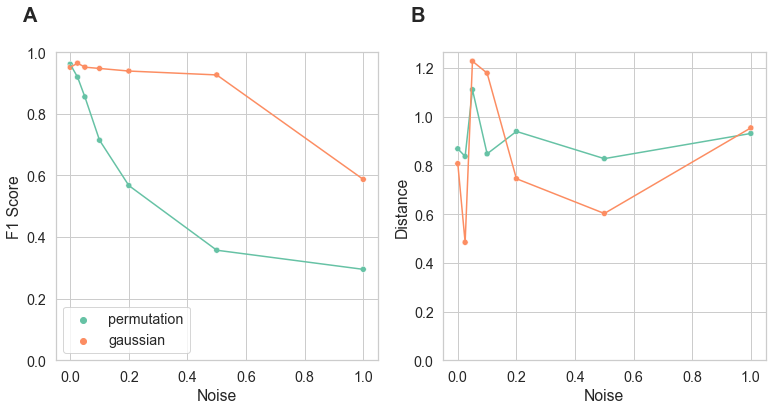

In [129]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))

############
# F1 score #
############

sns.scatterplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="f1",
    hue="kind",
    ax=axs[0]
)
sns.lineplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="f1",
    hue="kind",
    ax=axs[0],
    legend=False
)

axs[0].legend(loc="lower left")
axs[0].set_xlabel("Noise")
axs[0].set_ylabel("F1 Score")
axs[0].set_ylim(0, 1)

############
# Distance #
############

sns.scatterplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="distances",
    hue="kind",
    ax=axs[1],
    legend=False
)
sns.lineplot(
    data=pd.DataFrame(noise_results),
    x="noise",
    y="distances",
    hue="kind",
    ax=axs[1],
    legend=False
)

axs[1].set_xlabel("Noise")
axs[1].set_ylabel("Distance")
axs[1].set_ylim(0, None)


# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

In [130]:
fig.savefig(fname=os.path.join(FIG_SAVE_PATH, "experiment_noise.png"), dpi=300)